# Importing Libraries and loading in data

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio

In [3]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

In [4]:
files = glob.glob(r'D:\MAIAC_Data\Europe\h00v01\Projected\2014\*_PM25.tif')

In [4]:
list_of_das = map(maiac_file_to_da, files)
MAIAC_PM25 = xr.concat(list_of_das, 'time')

# Validating Southampton Centre
## Extracting data at the ground site

In [5]:
a = MAIAC_PM25.attrs['affine']
a = rasterio.Affine.from_gdal(*a)
~a * (442579, 112248)

(1106.3836110057598, 1048.137442006313)

In [6]:
folders = glob.glob(r'D:\MAIAC_Data\Europe\h00v01\Projected\20*')

In [7]:
for folder in folders:
    files = glob.glob(r'{fname}\*_PM25.tif'.format(fname=folder))
    list_of_das = map(maiac_file_to_da, files)
    MAIAC_PM25 = xr.concat(list_of_das, 'time')
    reordered_MAIAC_PM25 = MAIAC_PM25.isel(time=np.argsort(MAIAC_PM25.time))
    Measurements = reordered_MAIAC_PM25.isel(x=1106, y=1048).dropna('time').to_dataframe(name='MAIAC_PM25')
    Measurements.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_MAIAC_PM25.csv', mode='a')
    print('Processed {fname}'.format(fname=folder))

Processed D:\MAIAC_Data\Europe\h00v01\Projected\2000
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2001
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2002
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2003
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2004
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2005
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2006
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2007
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2008
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2009
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2010
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2011
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2012
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2013
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2014


## Comparing the MAIAC and groundbased data

In [2]:
!head -n 30 'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Southampton2008_2014.csv'

Date,Time,PM2.5_Soton_Centre,Status
06/11/2008,01:00:00,26,V ugm-3 (TEOM FDMS)
06/11/2008,02:00:00,18,V ugm-3 (TEOM FDMS)
06/11/2008,03:00:00,19,V ugm-3 (TEOM FDMS)
06/11/2008,04:00:00,22,V ugm-3 (TEOM FDMS)
06/11/2008,05:00:00,25,V ugm-3 (TEOM FDMS)
06/11/2008,06:00:00,36,V ugm-3 (TEOM FDMS)
06/11/2008,07:00:00,39,V ugm-3 (TEOM FDMS)
06/11/2008,08:00:00,37,V ugm-3 (TEOM FDMS)
06/11/2008,09:00:00,41,V ugm-3 (TEOM FDMS)
06/11/2008,10:00:00,32,V ugm-3 (TEOM FDMS)
06/11/2008,11:00:00,31,V ugm-3 (TEOM FDMS)
06/11/2008,12:00:00,36,V ugm-3 (TEOM FDMS)
06/11/2008,13:00:00,33,V ugm-3 (TEOM FDMS)
06/11/2008,14:00:00,25,V ugm-3 (TEOM FDMS)
06/11/2008,15:00:00,30,V ugm-3 (TEOM FDMS)
06/11/2008,16:00:00,28,V ugm-3 (TEOM FDMS)
06/11/2008,17:00:00,26,V ugm-3 (TEOM FDMS)
06/11/2008,18:00:00,32,V ugm-3 (TEOM FDMS)
06/11/2008,19:00:00,36,V ugm-3 (TEOM FDMS)
06/11/2008,20:00:00,38,V ugm-3 (TEOM FDMS)
06/11/2008,21:00:00,34,V ugm-3 (TEOM FDMS)
06/11/2008,22:00:00,32,V ugm-3 (TEOM FDMS)
06/11/2008,23:00:0

In [3]:
AURN_Soton = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Southampton2008_2014.csv', 
                         parse_dates = {'timestamp': ['Date', 'Time']}, infer_datetime_format=True, dayfirst=True, na_values=['No data'])

In [4]:
from dateutil.parser import parse

In [5]:
AURN_Soton['Had24'] = AURN_Soton.timestamp.str.contains(' 24:')

In [6]:
AURN_Soton['timestamp'] = AURN_Soton.timestamp.str.replace(' 24:', ' 00:')

In [7]:
AURN_Soton['timestamp'] = pd.to_datetime(AURN_Soton.timestamp, format='%d/%m/%Y %H:%M:%S')

In [8]:
AURN_Soton.loc[AURN_Soton.Had24, 'timestamp'] = AURN_Soton.query('Had24 == True').timestamp + pd.Timedelta('1d')

In [9]:
AURN_Soton = AURN_Soton.set_index('timestamp')

In [10]:
AURN_Soton.head()

,PM2.5_Soton_Centre,Status,Had24
timestamp,,,
2008-11-06 01:00:00,26.0,V ugm-3 (TEOM FDMS),False
2008-11-06 02:00:00,18.0,V ugm-3 (TEOM FDMS),False
2008-11-06 03:00:00,19.0,V ugm-3 (TEOM FDMS),False
2008-11-06 04:00:00,22.0,V ugm-3 (TEOM FDMS),False
2008-11-06 05:00:00,25.0,V ugm-3 (TEOM FDMS),False


In [11]:
AURN_Soton.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\AURN_Soton.csv')

In [12]:
MAIAC_Soton = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_MAIAC_PM25.csv', parse_dates=['time'])

In [13]:
MAIAC_Soton = MAIAC_Soton.set_index('time')

In [14]:
MAIAC_Soton.head()

,x,y,MAIAC_PM25
time,,,
2000-02-25 10:50:00,442096.9763,112420.7018,23.026955
2000-02-28 11:25:00,442096.9763,112420.7018,36.062874
2000-03-03 12:35:00,442096.9763,112420.7018,20.079552
2000-12-03 12:30:00,442096.9763,112420.7018,25.816568
2000-08-04 10:35:00,442096.9763,112420.7018,27.164116


In [15]:
MAIAC_Soton['time'] = MAIAC_Soton.index

In [16]:
MAIAC_Soton = MAIAC_Soton.drop_duplicates(subset='time')

In [17]:
MAIAC_Soton = MAIAC_Soton.sort_index()

In [18]:
indexed = MAIAC_Soton.reindex(AURN_Soton.index, method='nearest', tolerance='10Min').dropna()

In [19]:
result = pd.merge(AURN_Soton, indexed, left_index=True, right_index=True).reset_index().rename(columns={'time':'AURN_Time', 'timestamp':'MAIAC_Time'})

In [20]:
result = result[['MAIAC_Time', 'AURN_Time', 'PM2.5_Soton_Centre', 'MAIAC_PM25']].dropna()

In [21]:
result.isnull().sum()

MAIAC_Time            0
AURN_Time             0
PM2.5_Soton_Centre    0
MAIAC_PM25            0
dtype: int64

In [22]:
%matplotlib inline

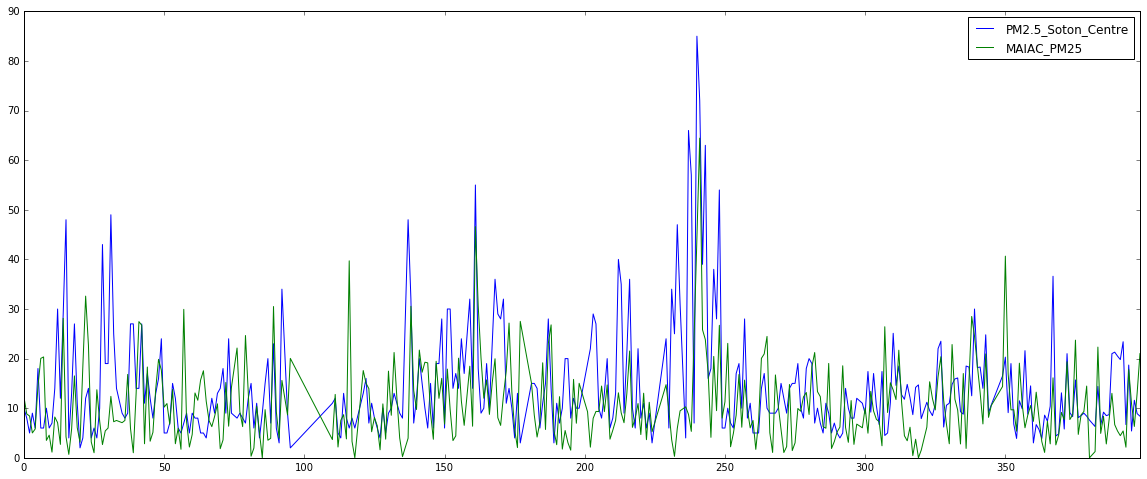

In [23]:
result.plot(figsize=(20, 8))

In [24]:
result['error'] = result['PM2.5_Soton_Centre'] - result['MAIAC_PM25']

In [25]:
result.error.abs().describe()

count    362.000000
mean       8.059675
std        8.499346
min        0.038878
25%        2.281614
50%        5.484178
75%       10.943085
max       57.245951
Name: error, dtype: float64

In [26]:
(result.error > 20).sum()

23

In [27]:
len(result)

362

In [28]:
result.ix[result.MAIAC_PM25 > 15]

,MAIAC_Time,AURN_Time,PM2.5_Soton_Centre,MAIAC_PM25,error
6,2008-12-04 12:00:00,2008-12-04 12:10:00,6.0,20.042711,-14.042711
7,2008-12-04 14:00:00,2008-12-04 14:00:00,6.0,20.336378,-14.336378
14,2009-01-09 12:00:00,2009-01-09 12:05:00,29.0,28.123997,0.876003
18,2009-01-27 12:00:00,2009-01-27 12:00:00,27.0,16.513691,10.486309
21,2009-02-03 12:00:00,2009-02-03 12:00:00,4.0,18.376377,-14.376377
22,2009-02-04 11:00:00,2009-02-04 11:05:00,12.0,32.596939,-20.596939
23,2009-02-04 13:00:00,2009-02-04 12:55:00,14.0,22.685707,-8.685707
37,2009-04-04 11:00:00,2009-04-04 10:50:00,9.0,16.812386,-7.812386
41,2009-04-19 10:00:00,2009-04-19 10:05:00,14.0,27.457783,-13.457783
42,2009-04-20 11:00:00,2009-04-20 10:50:00,27.0,26.723618,0.276382


In [30]:
result.MAIAC_PM25.describe()

count    362.000000
mean      10.937988
std        8.309973
min        0.000000
25%        5.220956
50%        8.942549
75%       15.107771
max       64.451775
Name: MAIAC_PM25, dtype: float64

In [31]:
result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Southampton\Soton_validation.csv')

# Validating Bournemouth
## Extracting data at the ground site

In [8]:
a = MAIAC_PM25.attrs['affine']
a = rasterio.Affine.from_gdal(*a)
~a * (412322, 93343)

(1082.3040538889738, 1063.182688636608)

In [9]:
for folder in folders:
    files = glob.glob(r'{fname}\*_PM25.tif'.format(fname=folder))
    list_of_das = map(maiac_file_to_da, files)
    MAIAC_PM25 = xr.concat(list_of_das, 'time')
    reordered_MAIAC_PM25 = MAIAC_PM25.isel(time=np.argsort(MAIAC_PM25.time))
    Measurements = reordered_MAIAC_PM25.isel(x=1082, y=1063).dropna('time').to_dataframe(name='MAIAC_PM25')
    Measurements.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_MAIAC_PM25.csv', mode='a')
    print('Processed {fname}'.format(fname=folder))

Processed D:\MAIAC_Data\Europe\h00v01\Projected\2000
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2001
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2002
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2003
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2004
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2005
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2006
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2007
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2008
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2009
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2010
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2011
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2012
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2013
Processed D:\MAIAC_Data\Europe\h00v01\Projected\2014


## Comparing MAIAC and groundbased

In [33]:
AURN_Bmth = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bournemouth2008_2014.csv')

In [34]:
MAIAC_Bmth = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AURN\Bournemouth\Bmth_MAIAC_PM25.csv')

In [36]:
MAIAC_Bmth[:10]

,time,x,y,MAIAC_PM25
0,2000-02-25 10:50:00,411939.94320081966,93572.55613552616,16.433635711669922
1,2000-03-12 12:30:00,411939.94320081966,93572.55613552616,16.46393394470215
2,2000-03-19 12:35:00,411939.94320081966,93572.55613552616,17.86511993408203
3,2000-04-06 12:25:00,411939.94320081966,93572.55613552616,17.33671760559082
4,2000-04-07 11:30:00,411939.94320081966,93572.55613552616,26.186424255371094
5,2000-04-08 10:35:00,411939.94320081966,93572.55613552616,23.937726974487305
6,2000-04-08 12:15:00,411939.94320081966,93572.55613552616,19.3677978515625
7,2000-04-10 12:00:00,411939.94320081966,93572.55613552616,16.75640869140625
8,2000-04-29 10:55:00,411939.94320081966,93572.55613552616,20.455875396728516
9,2000-05-01 10:40:00,411939.94320081966,93572.55613552616,21.390899658203125


In [41]:
MAIAC_Bmth.dtypes

time          object
x             object
y             object
MAIAC_PM25    object
dtype: object

In [42]:
MAIAC_Bmth.MAIAC_PM25

TypeError: 'Series' object is not callable

In [35]:
MAIAC_Bmth_Max = MAIAC_Bmth.resample('D', dim='time', how='median')

TypeError: resample() got an unexpected keyword argument 'dim'

In [39]:
MAIAC_Bmth['means'] = MAIAC_Bmth.groupby('time')['MAIAC_PM25'].mean()

DataError: No numeric types to aggregate